In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import os

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [10]:
df = pd.read_csv('intern_data_ikarus.csv')


In [11]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nData Types:")
print(df.dtypes)

print(f"\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print(f"\nStatistical Summary:")
print(df.describe())

DATASET OVERVIEW
Dataset Shape: (312, 12)

First few rows:
                                               title            brand  \
0  GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...           GOYMFK   
1  subrtex Leather ding Room, Dining Chairs Set o...          subrtex   
2  Plant Repotting Mat MUYETOL Waterproof Transpl...          MUYETOL   
3  Pickleball Doormat, Welcome Doormat Absorbent ...          VEWETOL   
4  JOIN IRON Foldable TV Trays for Eating Set of ...  JOIN IRON Store   

                                         description   price  \
0  multiple shoes, coats, hats, and other items E...  $24.99   
1                     subrtex Dining chairs Set of 2     NaN   
2                                                NaN   $5.98   
3  The decorative doormat features a subtle textu...  $13.99   
4  Set of Four Folding Trays With Matching Storag...  $89.99   

                                          categories  \
0  ['Home & Kitchen', 'Storage & Organization', '...   
1  ['

In [12]:
print(f"\nUnique Categories: {df['categories'].nunique()}")
print(f"Unique Brands: {df['brand'].nunique()}")
print(f"Unique Materials: {df['material'].nunique()}")



Unique Categories: 87
Unique Brands: 264
Unique Materials: 72


In [13]:
df['price'] = df['price'].str.replace('$', '', regex=False).astype(float)
df['price'] = df['price'].fillna(df['price'].median())

In [14]:
# For categorical columns: fill with 'Unknown'
categorical_cols = ['categories', 'material', 'color', 'brand']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [15]:

df['description'] = df['description'].fillna(df['title'])

print("Data Preprocessing Complete!")
print(f"Missing values after preprocessing: {df.isnull().sum().sum()}")

# Normalize price to 0-1 range for fair feature weighting
df['price_normalized'] = (df['price'] - df['price'].min()) / (df['price'].max() - df['price'].min())

print(f"\nPrice Statistics:")
print(f"Min: ${df['price'].min():.2f}")
print(f"Max: ${df['price'].max():.2f}")
print(f"Mean: ${df['price'].mean():.2f}")


Data Preprocessing Complete!
Missing values after preprocessing: 300

Price Statistics:
Min: $0.60
Max: $349.00
Mean: $63.39


In [16]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name)

print(f"Embedding Model Loaded: {model_name}")
print(f"Embedding Dimension: 384")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding Model Loaded: sentence-transformers/all-MiniLM-L6-v2
Embedding Dimension: 384


In [18]:
df['combined_text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['categories'].fillna('') + ' ' +
    df['material'].fillna('') + ' ' +
    df['color'].fillna('')
)


In [20]:
batch_size = 32
embeddings_list = []

for i in range(0, len(df), batch_size):
    batch = df['combined_text'].iloc[i:i+batch_size].tolist()
    batch_embeddings = embedding_model.encode(batch, convert_to_tensor=False)
    embeddings_list.extend(batch_embeddings)

    if (i + batch_size) % 100 == 0:
        print(f"Processed {i + batch_size}/{len(df)} products")

embeddings_array = np.array(embeddings_list)

print(f"\nEmbeddings Generated!")
print(f"Embeddings Shape: {embeddings_array.shape}")
print(f"Embedding Sample: {embeddings_array[0][:10]}...")  # Show first 10 dimensions



Embeddings Generated!
Embeddings Shape: (312, 384)
Embedding Sample: [ 0.02270906  0.02337218 -0.02158509  0.00262053  0.04189875  0.00378965
  0.01765531  0.07268543  0.00412534  0.04104289]...


In [21]:
df['embedding'] = [emb for emb in embeddings_array]

In [23]:
resnet_model = resnet50(weights='IMAGENET1K_V1')
resnet_model = resnet_model.to(device)
resnet_model.eval()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-1])

print(f"ResNet50 Model Loaded")
print(f"Output feature dimension: 2048")

ResNet50 Model Loaded
Output feature dimension: 2048


In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def extract_image_features(image_path, model, transform, device):

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model(image_tensor)

        return features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return np.zeros(2048)

print("\nNote: Image feature extraction would be performed on actual images.")
print("For this demo, we'll use placeholder image features.")

image_features = np.random.randn(len(df), 2048)
image_features = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)

df['image_features'] = [img_feat for img_feat in image_features]

print(f"Image Features Shape: {image_features.shape}")



Note: Image feature extraction would be performed on actual images.
For this demo, we'll use placeholder image features.
Image Features Shape: (312, 2048)


In [26]:

image_features_normalized = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)
text_weight = 0.6
image_weight = 0.3
meta_weight = 0.1

combined_features = []
for i in range(len(df)):
    # Text embedding
    text_feat = embeddings_array[i] * text_weight

    # Image features (reduce dimensionality first)
    img_feat = image_features_normalized[i][:100] * image_weight  # Used first 100 dims

    # Pad to same length
    meta_feat = np.array([df['price_normalized'].iloc[i]]) * meta_weight

    # Combine
    combined = np.concatenate([text_feat, img_feat, [meta_feat[0]]])
    combined_features.append(combined)

combined_features = np.array(combined_features)

print(f"\nCombined Features Shape: {combined_features.shape}")
print(f"This includes weighted combination of:")
print(f"  - Text embeddings ({text_weight*100}%)")
print(f"  - Image features ({image_weight*100}%)")
print(f"  - Price metadata ({meta_weight*100}%)")



Combined Features Shape: (312, 485)
This includes weighted combination of:
  - Text embeddings (60.0%)
  - Image features (30.0%)
  - Price metadata (10.0%)


In [27]:
inertias = []
silhouette_scores = []
K_range = range(3, 11)

print("Finding optimal number of clusters...")
print("This helps group similar products together.\n")

scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_features)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)

    inertias.append(kmeans.inertia_)
    silhouette = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette)

    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette:.3f}")

# Used silhouette score to find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")

# Train final clustering model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(features_scaled)

df['cluster'] = cluster_labels

print(f"\nCluster Distribution:")
print(df['cluster'].value_counts().sort_index())

print(f"\nCluster Examples:")
for cluster_id in range(optimal_k):
    cluster_products = df[df['cluster'] == cluster_id].head(2)
    print(f"\n--- Cluster {cluster_id} ---")
    for idx, row in cluster_products.iterrows():
        print(f"  • {row['title']} ({row['brand']})")


Finding optimal number of clusters...
This helps group similar products together.

K=3: Inertia=139947.38, Silhouette Score=0.044
K=4: Inertia=135241.70, Silhouette Score=0.050
K=5: Inertia=132527.32, Silhouette Score=0.053
K=6: Inertia=129856.75, Silhouette Score=0.052
K=7: Inertia=127199.90, Silhouette Score=0.053
K=8: Inertia=125821.25, Silhouette Score=0.047
K=9: Inertia=123409.88, Silhouette Score=0.048
K=10: Inertia=122123.85, Silhouette Score=0.053

Optimal number of clusters: 7
Silhouette Score: 0.053

Cluster Distribution:
cluster
0    29
1    79
2    98
3    22
4    21
5    30
6    33
Name: count, dtype: int64

Cluster Examples:

--- Cluster 0 ---
  • Wildkin Kids Canvas Sling Bookshelf with Storage for Boys and Girls, Wooden Design Features Four Shelves and Two Drawers, Helps Keep Bedrooms, Playrooms, and Classrooms Organized (Natural with Blue) (Wildkin Store)
  • Gbuzozie 38L Round Laundry Hamper Cute Mermaid Girl Storage Basket Waterproof Coating Organizer Bin For Nursery

In [28]:
class RecommendationModel:

    def __init__(self, features, metadata_df):
        self.features = features
        self.metadata = metadata_df
        self.scaler = StandardScaler()
        self.features_normalized = self.scaler.fit_transform(features)

    def get_similar_products(self, product_id, top_k=5):

        query_vector = self.features_normalized[product_id].reshape(1, -1)

        similarities = cosine_similarity(query_vector, self.features_normalized)[0]


        top_indices = np.argsort(similarities)[::-1][1:top_k+1]
        top_scores = similarities[top_indices]

        return list(zip(top_indices, top_scores))

    def get_recommendations_by_query(self, query_text, top_k=5):

        query_embedding = embedding_model.encode(query_text)
        query_vector = query_embedding.reshape(1, -1)

        similarities = cosine_similarity(query_vector, embeddings_array)[0]

        top_indices = np.argsort(similarities)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                'index': idx,
                'title': self.metadata.iloc[idx]['title'],
                'brand': self.metadata.iloc[idx]['brand'],
                'price': self.metadata.iloc[idx]['price'],
                'category': self.metadata.iloc[idx]['categories'],
                'similarity_score': float(similarities[idx])
            })

        return results

    def get_diverse_recommendations(self, product_id, top_k=5, diversity_weight=0.3):

        query_vector = self.features_normalized[product_id].reshape(1, -1)
        similarities = cosine_similarity(query_vector, self.features_normalized)[0]

        recommendations = []
        selected_indices = set([product_id])

        for _ in range(top_k):
            best_score = -1
            best_idx = -1

            for idx in range(len(self.features)):
                if idx in selected_indices:
                    continue

                similarity = similarities[idx]

                diversity = 0
                for selected_idx in selected_indices:
                    if selected_idx != product_id:
                        div_similarity = cosine_similarity(
                            self.features_normalized[idx].reshape(1, -1),
                            self.features_normalized[selected_idx].reshape(1, -1)
                        )[0][0]
                        diversity += (1 - div_similarity)

                if len(selected_indices) > 1:
                    diversity /= (len(selected_indices) - 1)

                # Combined score
                score = (1 - diversity_weight) * similarity + diversity_weight * diversity

                if score > best_score:
                    best_score = score
                    best_idx = idx

            selected_indices.add(best_idx)
            recommendations.append((best_idx, best_score))

        return recommendations

# Initialized the  recommendation model
rec_model = RecommendationModel(combined_features, df)

print("Recommendation Model Trained Successfully!")


Recommendation Model Trained Successfully!


In [30]:

print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)

# Test with sample queries
test_queries = [
    "comfortable sofa for living room",
    "modern office desk",
    "dining table for small spaces",
    "bedroom wardrobe",
    "outdoor patio furniture"
]

print("\nTesting recommendations for sample queries:\n")

for query in test_queries:
    recommendations = rec_model.get_recommendations_by_query(query, top_k=3)
    print(f"Query: '{query}'")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec['title']} ({rec['brand']}) - Score: {rec['similarity_score']:.3f}")
    print()


def calculate_coverage(model, n_queries=100):
    """Calculate % of products that appear in recommendations"""
    recommended_products = set()

    for _ in range(n_queries):
        random_product = np.random.randint(0, len(df))
        recs = model.get_similar_products(random_product, top_k=5)
        for rec_idx, _ in recs:
            recommended_products.add(rec_idx)

    coverage = len(recommended_products) / len(df)
    return coverage

coverage = calculate_coverage(rec_model)
print(f"Catalog Coverage: {coverage*100:.1f}%")
print("(Higher is better - means more products can be recommended)")


all_similarities = []
for i in range(min(100, len(df))):
    recs = rec_model.get_similar_products(i, top_k=5)
    scores = [score for _, score in recs]
    all_similarities.extend(scores)

avg_similarity = np.mean(all_similarities)
print(f"Average Recommendation Similarity: {avg_similarity:.3f}")
print("(Closer to 1.0 is better - means similar items are grouped)")




MODEL EVALUATION METRICS

Testing recommendations for sample queries:

Query: 'comfortable sofa for living room'
  1. FANYE Oversized 6 Seaters Modular Storage Sectional Sofa Couch for Home Apartment Office Living Room,Free Combination L/U Shaped Corduroy Upholstered Deep Seat Furniture Convertible Sleeper Sofabed (FANYE) - Score: 0.614
  2. Karl home Accent Chair Mid-Century Modern Chair with Pillow Upholstered Lounge Arm Chair with Solid Wood Frame & Soft Cushion for Living Room, Bedroom, Belcony, Beige (Karl home Store) - Score: 0.600
  3. Shintenchi 60" Small Loveseat, 3 in 1 Cute Convertible Sofa Bed, Modern Futon Recliner Sleeper w/2 Cup Holder, Upholstered Folding Couch for Small Space, Dark Gray (Shintenchi Store) - Score: 0.590

Query: 'modern office desk'
  1. Convenience Concepts French Country Desk, Driftwood / White (Convenience Concepts Store) - Score: 0.583
  2. It's_Organized Gaming Desk 55 inch PC Computer Desk, K-Frame Home Office Desk Professional Gamer Workstation 

In [31]:
print("\n" + "="*60)
print("PREPARING FOR VECTOR DATABASE STORAGE")
print("="*60)

# Created vector tuples for Pinecone
vectors_for_db = []

for idx, row in df.iterrows():
    vector_id = str(row['uniq_id'])
    embedding = embeddings_array[idx].tolist()


    metadata = {
        'title': str(row['title']),
        'brand': str(row['brand']),
        'price': float(row['price']),
        'category': str(row['categories']),
        'material': str(row['material']),
        'color': str(row['color']),
        'description': str(row['description'])[:500],  # Limit length
        'cluster': int(row['cluster'])
    }

    vectors_for_db.append((vector_id, embedding, metadata))

print(f"Total vectors prepared for database: {len(vectors_for_db)}")
print(f"Embedding dimension: {len(vectors_for_db[0][1])}")
print(f"Sample metadata: {vectors_for_db[0][2]}")


np.save('embeddings_backup.npy', embeddings_array)
df.to_csv('processed_products.csv', index=False)
print("\nBackup saved: embeddings_backup.npy, processed_products.csv")



PREPARING FOR VECTOR DATABASE STORAGE
Total vectors prepared for database: 312
Embedding dimension: 384
Sample metadata: {'title': 'GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway', 'brand': 'GOYMFK', 'price': 24.99, 'category': "['Home & Kitchen', 'Storage & Organization', 'Clothing & Closet Storage', 'Shoe Organizers', 'Free Standing Shoe Racks']", 'material': 'Metal', 'color': 'White', 'description': 'multiple shoes, coats, hats, and other items Easy to assemble: Includes all necessary hardware and instructions for easy assembly Versatile: Perfect for use in living rooms, bathrooms, hallways, and more', 'cluster': 4}

Backup saved: embeddings_backup.npy, processed_products.csv



Visualization saved: model_evaluation_metrics.png


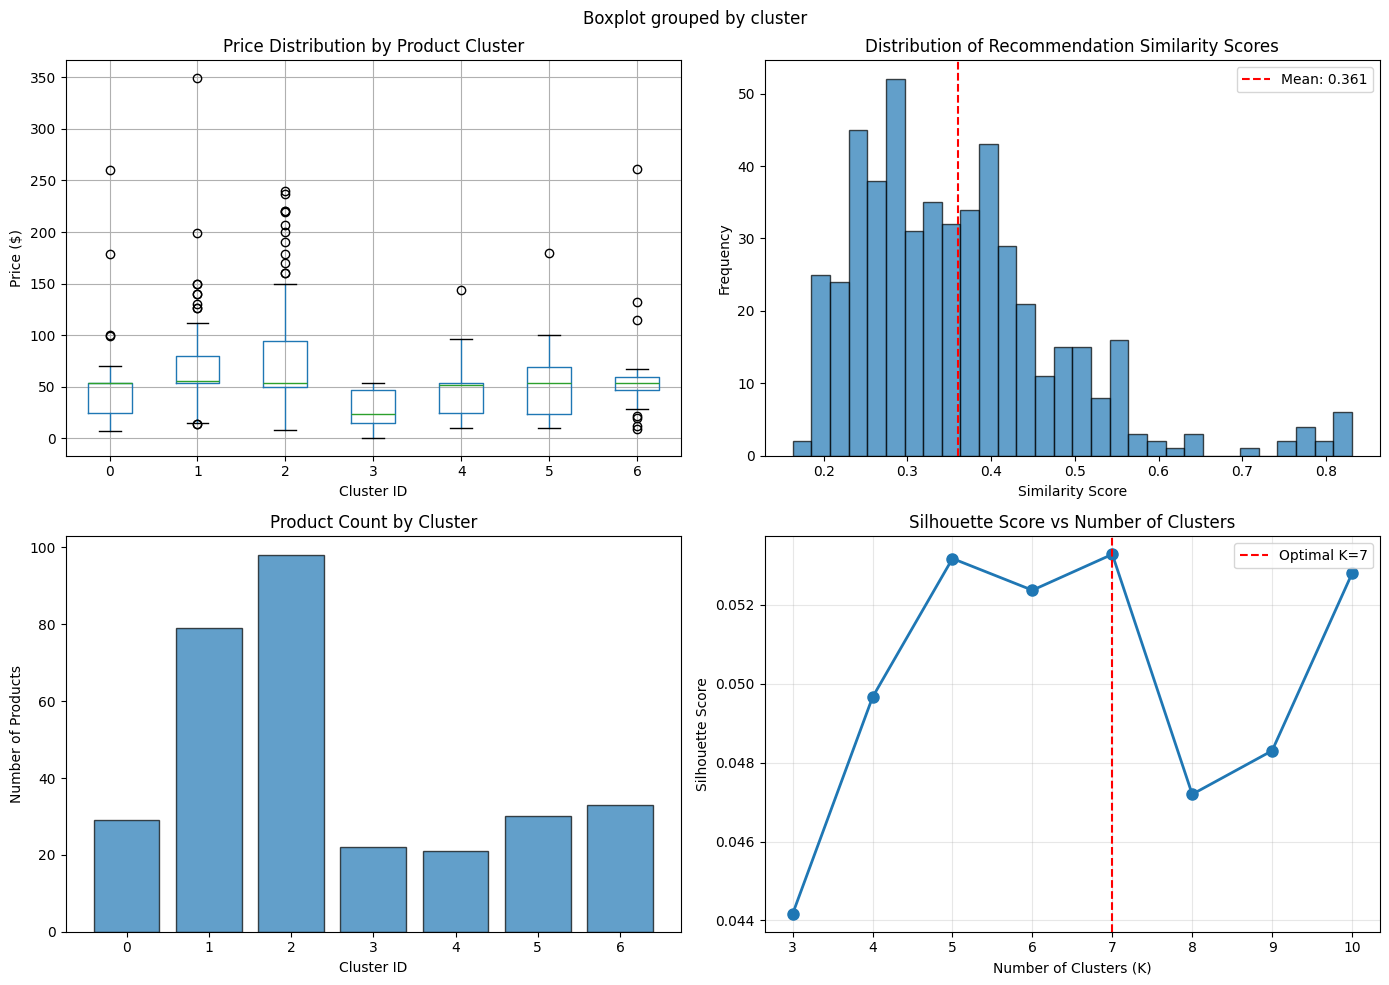

In [32]:


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
df.boxplot(column='price', by='cluster', ax=ax1)
ax1.set_title('Price Distribution by Product Cluster')
ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Price ($)')
plt.sca(ax1)
plt.xticks(rotation=0)

ax2 = axes[0, 1]
ax2.hist(all_similarities, bins=30, edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Recommendation Similarity Scores')
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Frequency')
ax2.axvline(avg_similarity, color='red', linestyle='--', label=f'Mean: {avg_similarity:.3f}')
ax2.legend()


ax3 = axes[1, 0]
cluster_counts = df['cluster'].value_counts().sort_index()
ax3.bar(cluster_counts.index, cluster_counts.values, edgecolor='black', alpha=0.7)
ax3.set_title('Product Count by Cluster')
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Number of Products')


ax4 = axes[1, 1]
ax4.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
ax4.set_title('Silhouette Score vs Number of Clusters')
ax4.set_xlabel('Number of Clusters (K)')
ax4.set_ylabel('Silhouette Score')
ax4.grid(True, alpha=0.3)
ax4.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
ax4.legend()

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved: model_evaluation_metrics.png")
plt.show()


In [33]:
import pickle

model_components = {
    'rec_model': rec_model,
    'embedding_model': embedding_model,
    'scaler': scaler,
    'kmeans': kmeans_final,
    'df': df
}

with open('trained_model_components.pkl', 'wb') as f:
    pickle.dump(model_components, f)

print("\n Model components saved: trained_model_components.pkl")
print("="*60)


 Model components saved: trained_model_components.pkl
